Link dataset 1: https://www.kaggle.com/datasets/grassknoted/asl-alphabet


Link dataset 2:https://www.kaggle.com/datasets/lexset/synthetic-asl-alphabet

In [11]:
import zipfile
import os
import json
import pandas as pd
from pathlib import Path
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from tqdm import tqdm
from PIL import Image
import cv2

# Caricamento Dataset da Kaggle

In [6]:
%pip install kaggle


Note: you may need to restart the kernel to use updated packages.


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "kaggle.json"

In [8]:
%kaggle datasets download -d grassknoted/asl-alphabet

UsageError: %%python is a cell magic, but the cell body is empty.


In [ ]:


# Define the path to your zip file
file_path = "is-a-block-structure-stable-or-unstable.zip" # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall("./dataset")  # Replace 'destination_folder' with your desired folder

# Caricamento dati

In [10]:
def load_data(data_dir,dim,grayscale=True):
    images = []
    labels = []
    color = cv2.IMREAD_COLOR
    if(grayscale):
        color = cv2.IMREAD_GRAYSCALE
    for root, dirs, files in os.walk(data_dir):
        for label_dir in dirs:
            label = os.path.basename(label_dir)
            label_path = os.path.join(root, label_dir)
            print(f"Caricamento della cartella {label}...")
            for image_file in os.listdir(label_path):
                if image_file.endswith('.jpg') or image_file.endswith('.png'):
                    image_path = os.path.join(label_path, image_file)
                    image = cv2.imread(image_path,color )
                    if image is not None:
                        image = cv2.resize(image, (dim, dim))
                       
                        images.append(image)
                        labels.append(label)
            print(f"Caricamento della cartella {label} completato.")

    return np.array(images), np.array(labels)

In [9]:
train_dir = 'dataset/asl_alphabet_train'
test_dir = 'dataset/asl_alphabet_test'
train_dir_2 = "dataset2/Train_Alphabet"
test_dir_2 = "dataset2/Test_Alphabet"

In [12]:
train_images, train_labels = load_data(train_dir,64,grayscale=False)

Caricamento della cartella asl_alphabet_train...
Caricamento della cartella asl_alphabet_train completato.
Caricamento della cartella R...
Caricamento della cartella R completato.
Caricamento della cartella U...
Caricamento della cartella U completato.
Caricamento della cartella I...
Caricamento della cartella I completato.
Caricamento della cartella N...
Caricamento della cartella N completato.
Caricamento della cartella G...
Caricamento della cartella G completato.
Caricamento della cartella Z...
Caricamento della cartella Z completato.
Caricamento della cartella T...
Caricamento della cartella T completato.
Caricamento della cartella S...
Caricamento della cartella S completato.
Caricamento della cartella A...
Caricamento della cartella A completato.
Caricamento della cartella F...
Caricamento della cartella F completato.
Caricamento della cartella O...
Caricamento della cartella O completato.
Caricamento della cartella H...
Caricamento della cartella H completato.
Caricamento della

## combinazione 2 dataset

In [7]:
train_images_2 , train_labels_2 = load_data(train_dir_2)

TypeError: load_data() missing 1 required positional argument: 'dim'

In [ ]:
train_images=np.vstack((train_images, train_images_2))

In [ ]:
train_labels= np.concatenate((train_labels,train_labels_2))

In [ ]:
test_images, test_labels = load_data(test_dir)

Caricamento della cartella asl_alphabet_test...
Caricamento della cartella asl_alphabet_test completato.
Caricamento della cartella R...
Caricamento della cartella R completato.
Caricamento della cartella U...
Caricamento della cartella U completato.
Caricamento della cartella I...
Caricamento della cartella I completato.
Caricamento della cartella N...
Caricamento della cartella N completato.
Caricamento della cartella G...
Caricamento della cartella G completato.
Caricamento della cartella Z...
Caricamento della cartella Z completato.
Caricamento della cartella T...
Caricamento della cartella T completato.
Caricamento della cartella S...
Caricamento della cartella S completato.
Caricamento della cartella A...
Caricamento della cartella A completato.
Caricamento della cartella F...
Caricamento della cartella F completato.
Caricamento della cartella O...
Caricamento della cartella O completato.
Caricamento della cartella H...
Caricamento della cartella H completato.
Caricamento della c

In [ ]:
train_images.shape

(111300, 64, 64)

## split dati

In [13]:
from sklearn.model_selection import train_test_split

# Dividi il set di addestramento in train e validation
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42,stratify=train_labels)

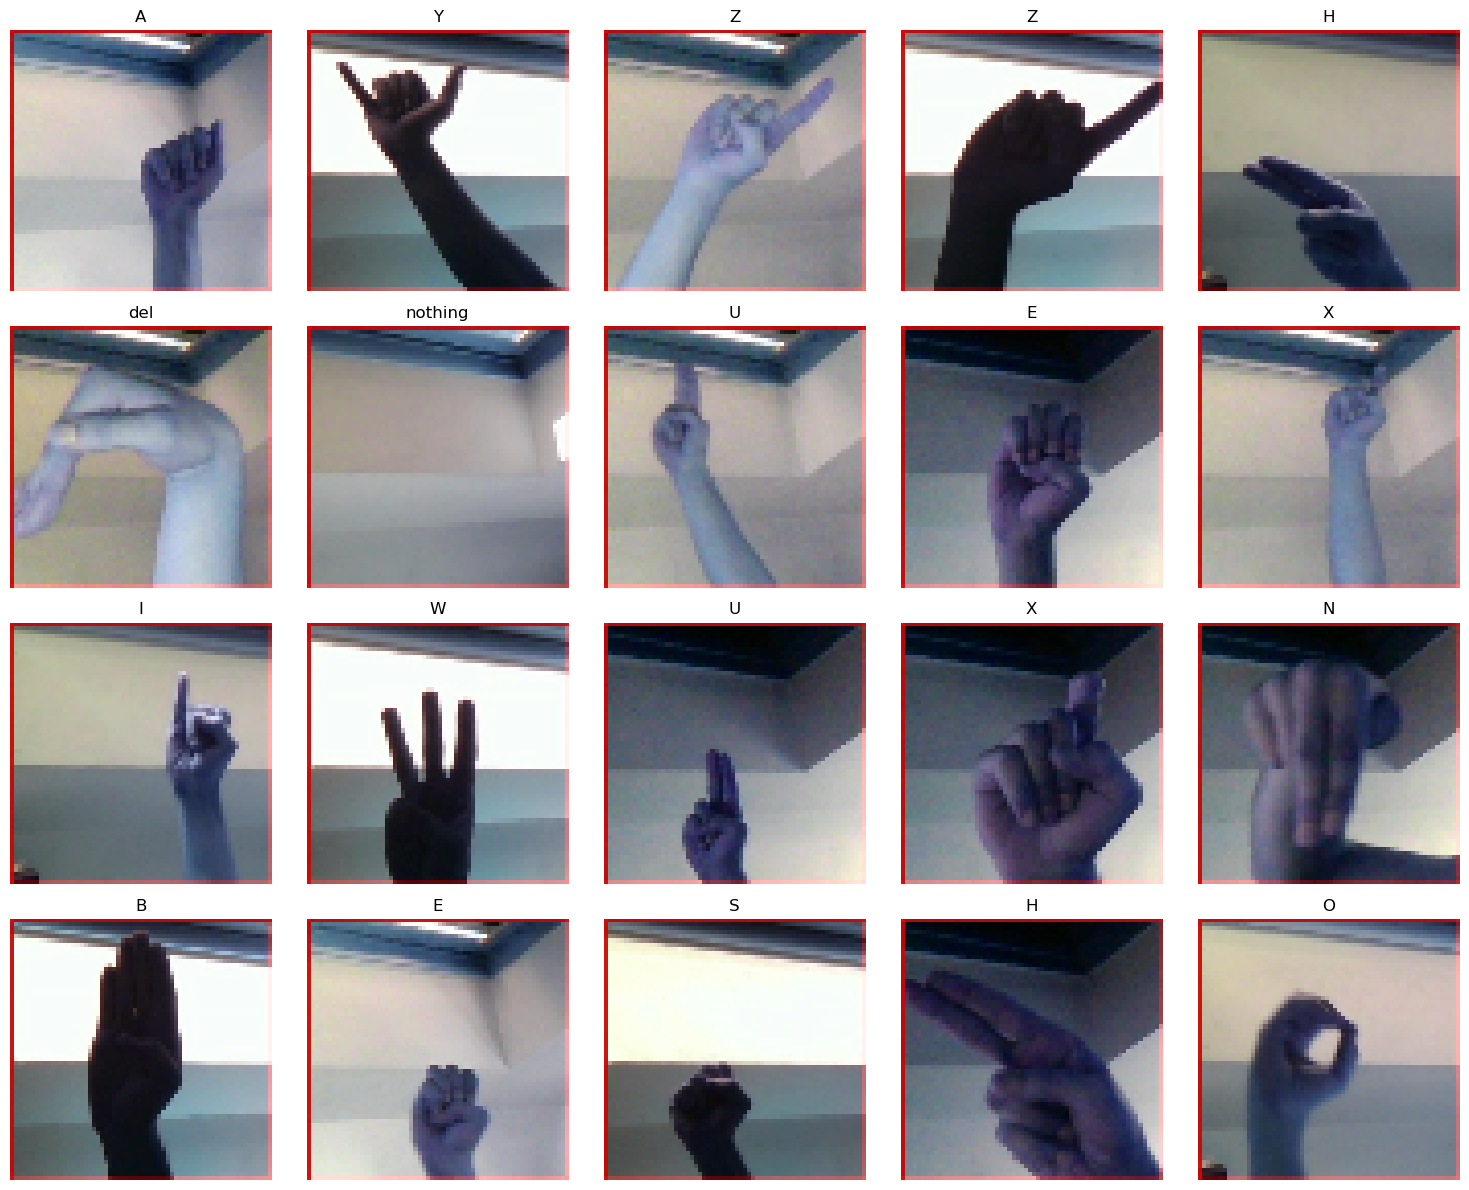

In [14]:
import matplotlib.pyplot as plt

# Numero di immagini da visualizzare
num_images = 20

# Calcola il numero di righe e colonne per il layout del subplot
num_cols = 5
num_rows = (num_images + num_cols - 1) // num_cols

plt.figure(figsize=(15, 3 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(train_images[i], cmap='gray')  # Usa 'gray' se le immagini sono in scala di grigi
    plt.title(train_labels[i])
    plt.axis('off')  # Nasconde gli assi

plt.tight_layout()
plt.show()


In [15]:
train_images.shape

(69600, 64, 64, 3)

In [16]:
val_images.shape

(17400, 64, 64, 3)

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [18]:
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)


In [19]:
df = pd.DataFrame(val_labels,columns=["label"])

/opt/anaconda3/envs/ML/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

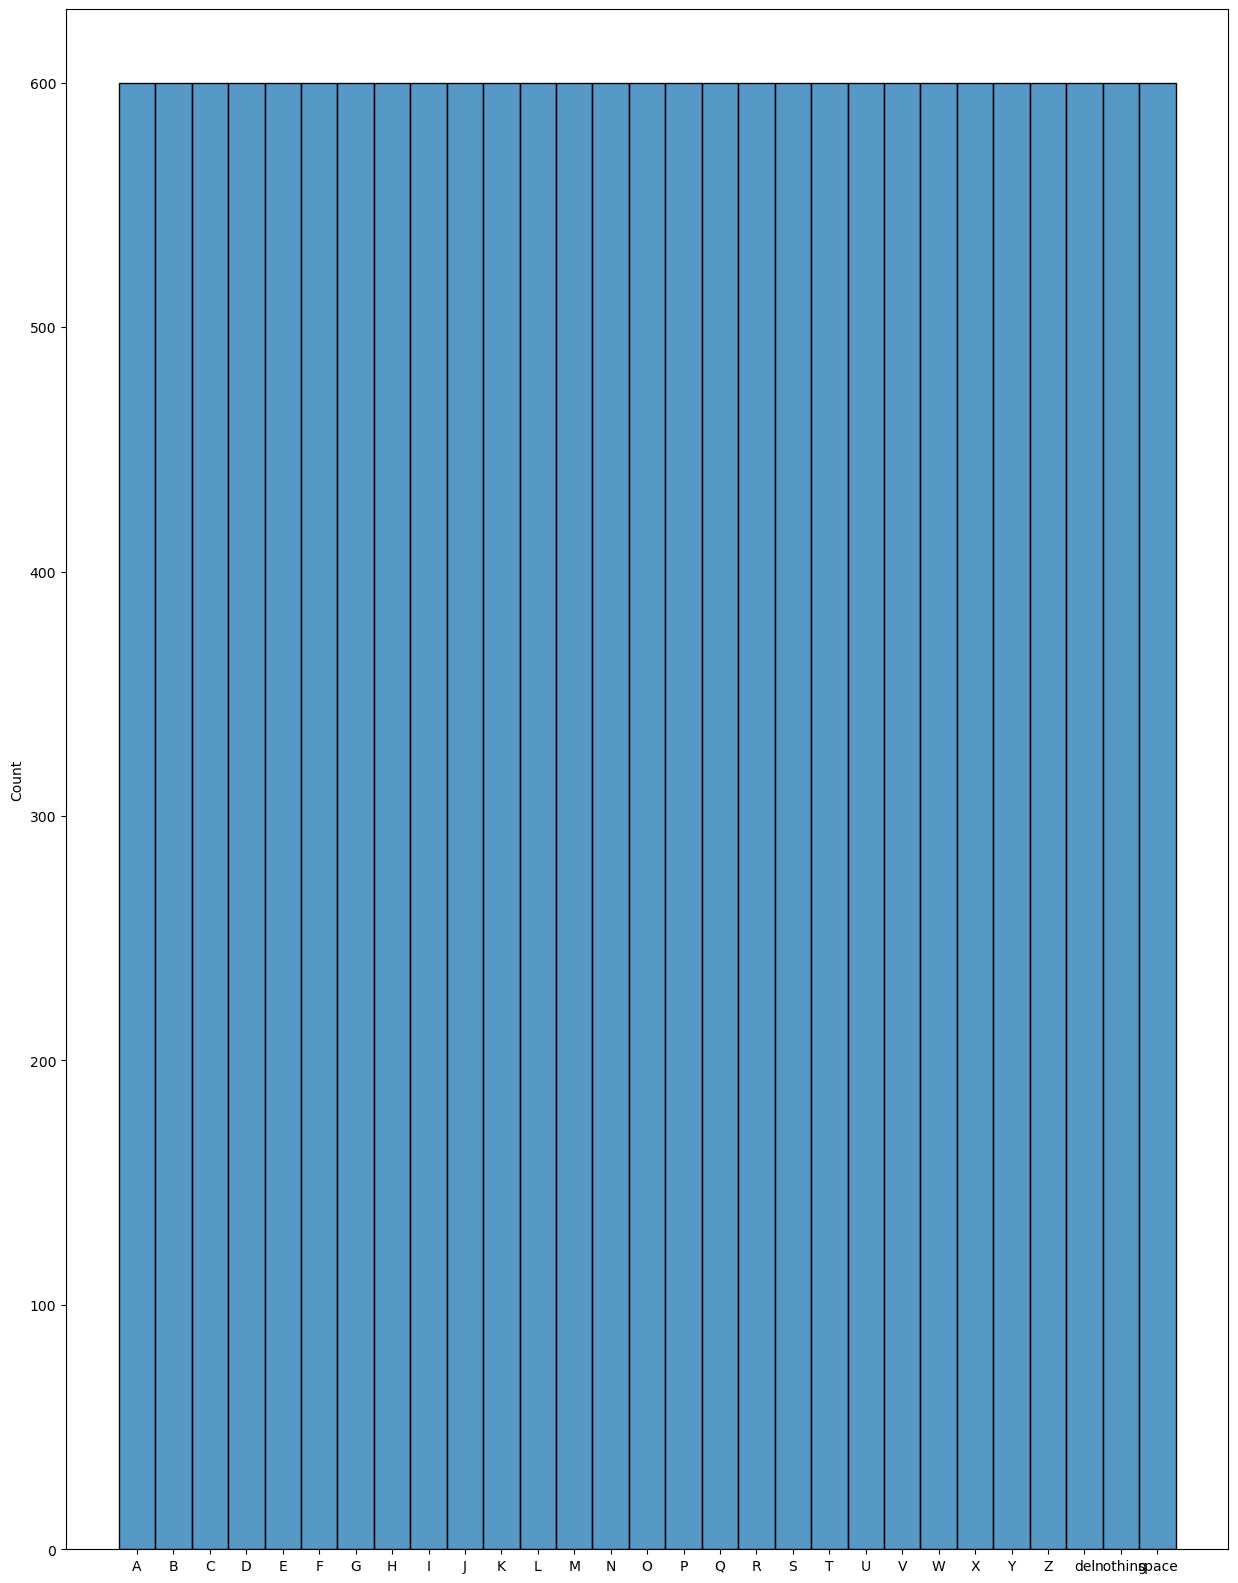

In [22]:
plt.figure(figsize=(15,20))
sns.histplot(data=sorted(df.label),discrete=True)

In [23]:
labels = sorted(set(val_labels)) 

In [ ]:
with open("labels2.json", 'w') as file_json:
    json.dump(labels, file_json)

# Numpy

In [24]:
train_images_norm = np.array(train_images)/255
val_images_norm = np.array(val_images)/255
#test_images_norm = np.array(test_images)/255

In [25]:
train_images_vectorized = train_images_norm.reshape(len(train_images_norm), -1)
val_images_vectorized = val_images_norm.reshape(len(val_images_norm), -1)
#test_images_vectorized = test_images_norm.reshape(len(test_images_norm), -1)

# Provo a visualizzare i dati 

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

## Pca

In [22]:
pca = PCA(2)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_images_vectorized)

In [23]:
train_pca.shape

(69600, 2)

In [24]:
train_pca_stable = train_pca[train_labels==1,:]

In [25]:
train_pca_unstable = train_pca[train_labels==0,:]

In [26]:
df = pd.DataFrame(train_pca,columns=["x","y"])

In [27]:
labels = pd.DataFrame(train_labels,columns=["labels"])

In [28]:
df = pd.concat([df,labels],axis=1)

In [29]:
df.shape

(69600, 3)

In [30]:
df.columns

Index(['x', 'y', 'labels'], dtype='object')

In [31]:
df.head()

,x,y,labels
0,-0.003733,-0.036216,A
1,0.033081,0.021496,Y
2,-0.004233,-0.024579,Z
3,0.021291,0.033344,Z
4,0.018388,0.020552,H


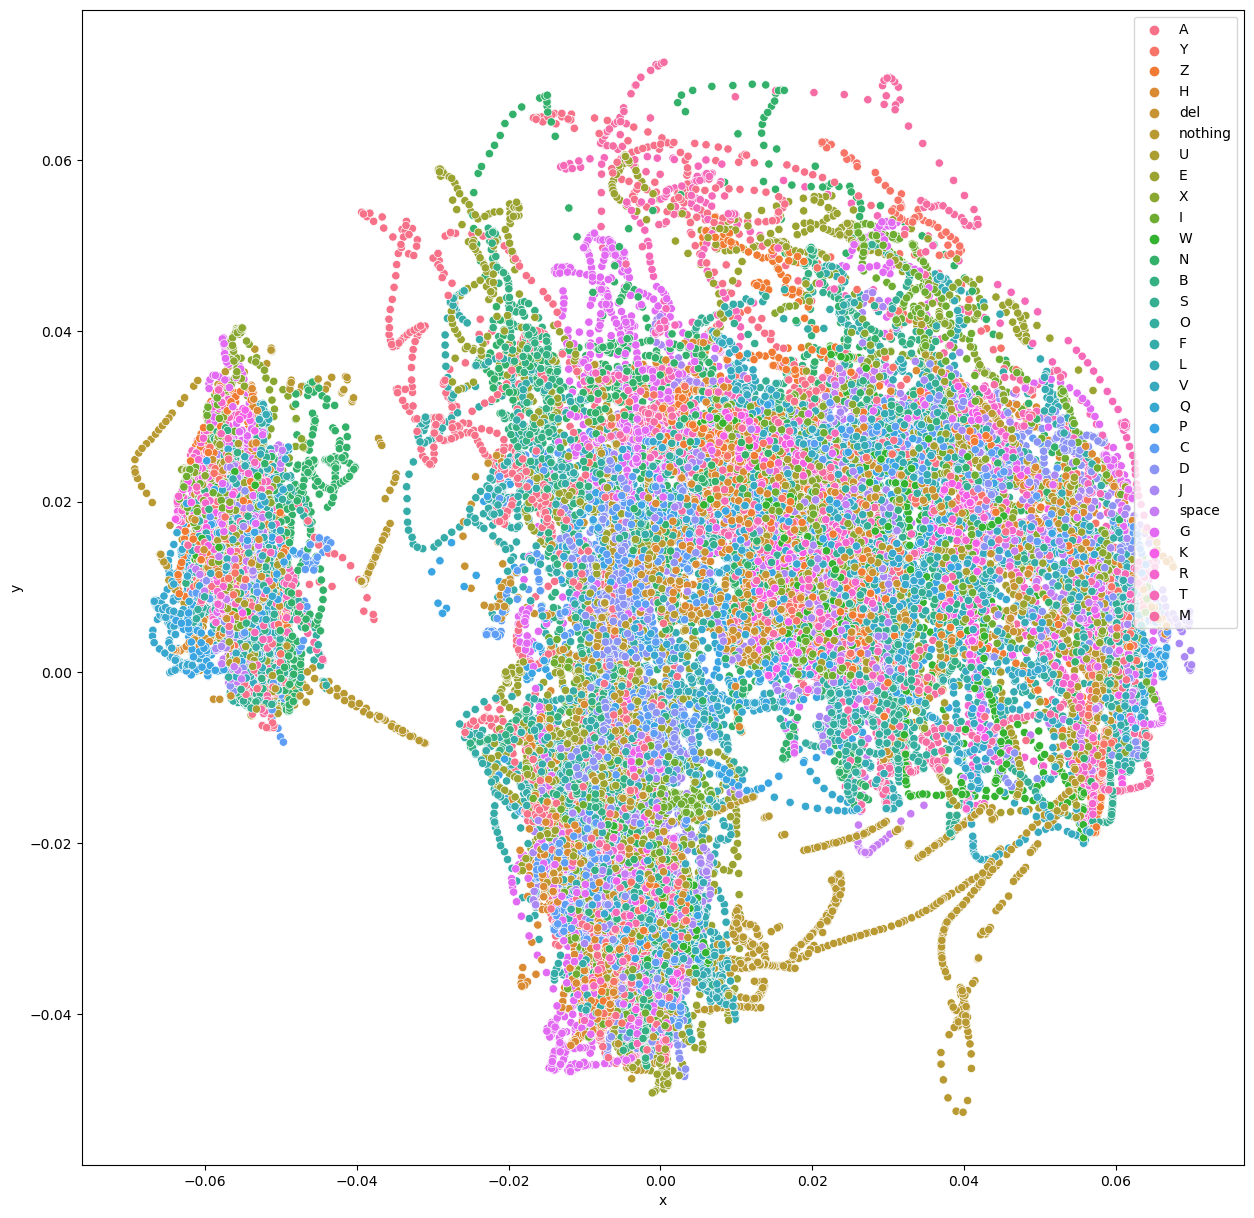

In [33]:
plt.figure(figsize=(15, 15))
sns.scatterplot(data=df,x="x",y="y", hue='labels')
plt.legend()
plt.show()

# Tentativo Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
clf = DecisionTreeClassifier(random_state=42)

# Addestra il modello
clf.fit(train_images_vectorized, train_labels)

# Predice i valori di test
y_pred = clf.predict(train_images_vectorized)

# Calcola l'accuratezza del modello
accuracy = accuracy_score(train_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

In [39]:
y_pred = clf.predict(val_images_vectorized)

In [41]:
accuracy = accuracy_score(val_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


In [ ]:
def stampa_previsioni(images,labels,num_images = 20):
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(15, 3 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i], cmap='gray')  # Usa 'gray' se le immagini sono in scala di grigi
        plt.title("Pred: "+y_pred[i]+f"\nActual: {labels[i]}")
        plt.axis('off')  # Nasconde gli assi

    plt.tight_layout()
    plt.show()

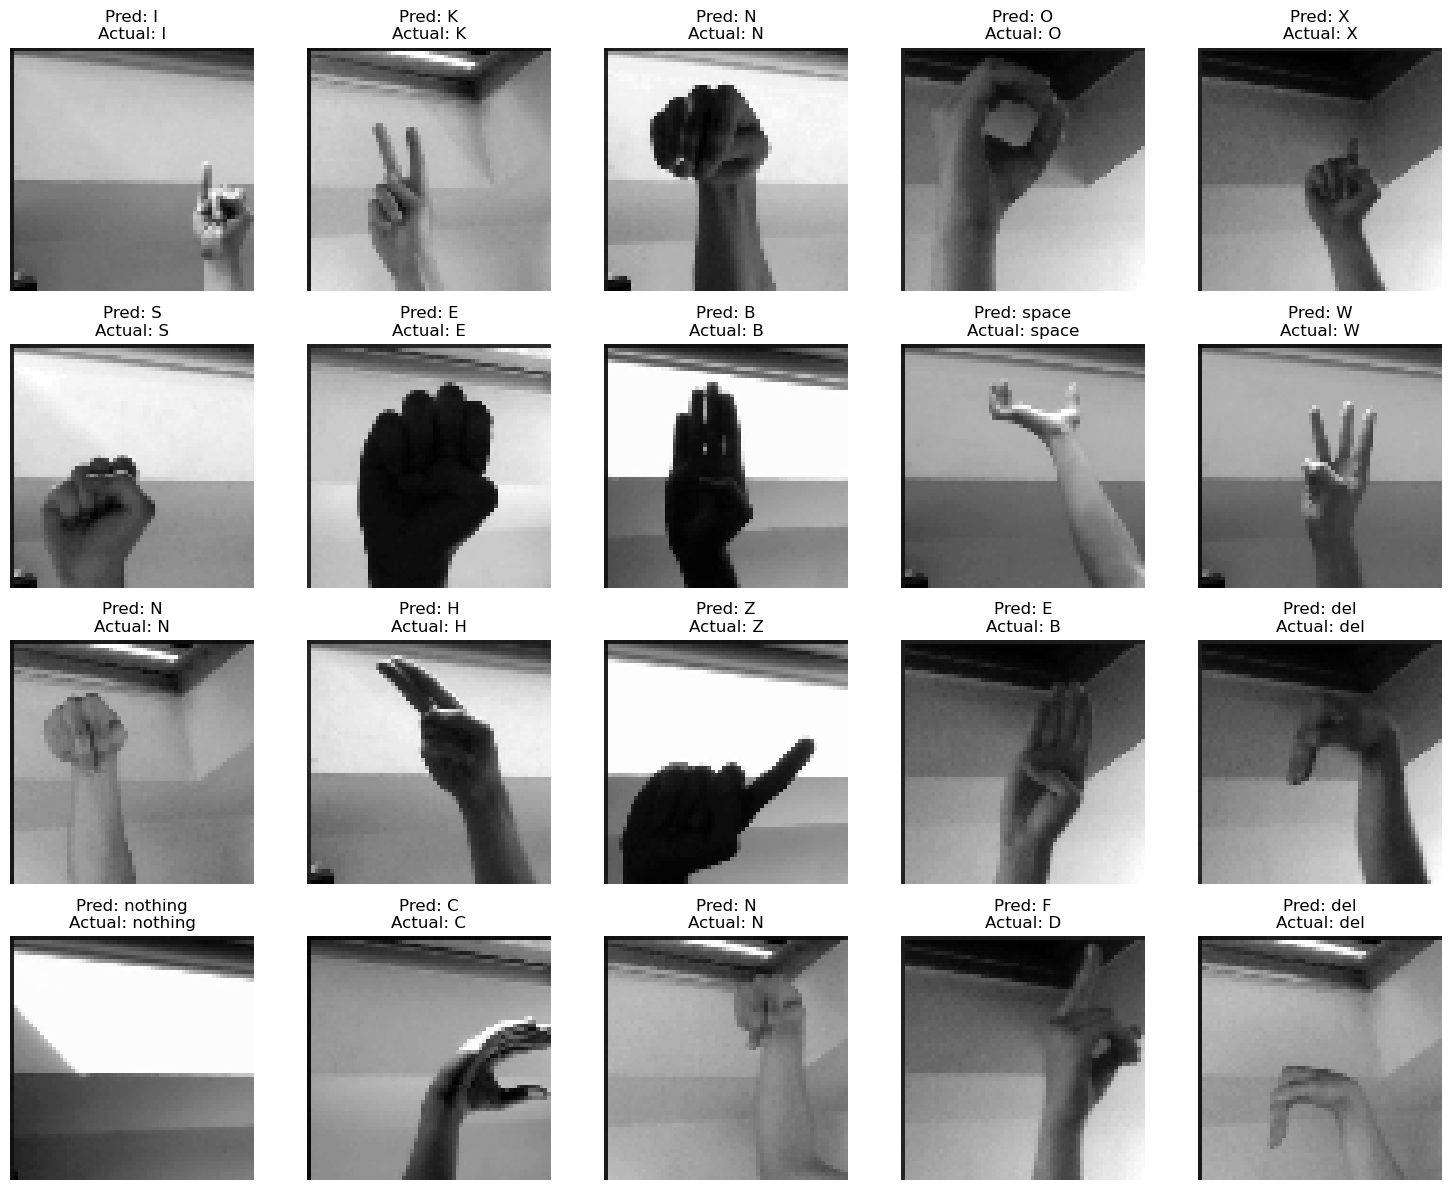

In [44]:
# Numero di immagini da visualizzare
num_images = 20

# Calcola il numero di righe e colonne per il layout del subplot
num_cols = 5
num_rows = (num_images + num_cols - 1) // num_cols

plt.figure(figsize=(15, 3 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(val_images[i], cmap='gray')  # Usa 'gray' se le immagini sono in scala di grigi
    plt.title("Pred: "+y_pred[i]+f"\nActual: {val_labels[i]}")
    plt.axis('off')  # Nasconde gli assi

plt.tight_layout()
plt.show()

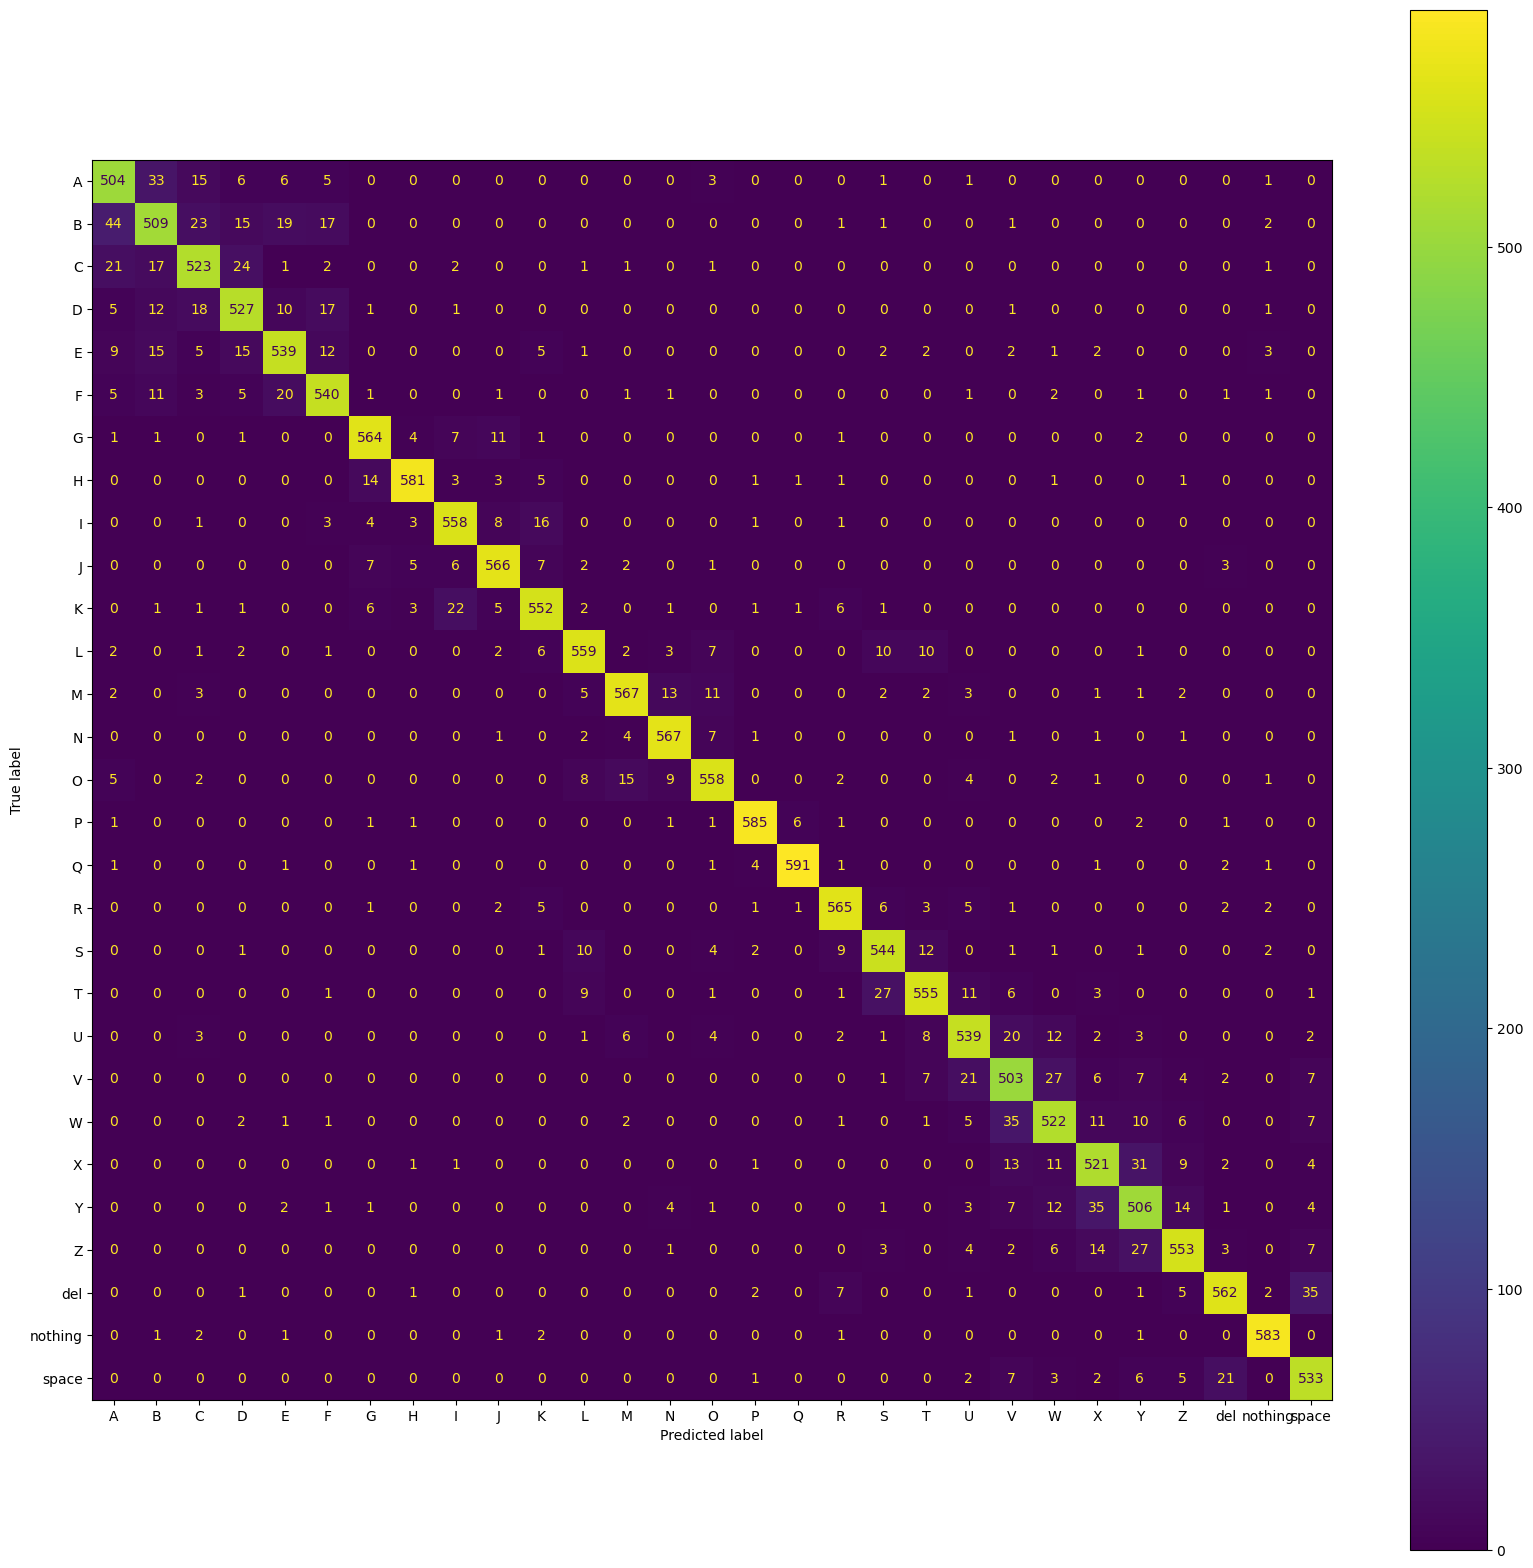

In [71]:
fig,ax=plt.subplots(figsize=(20, 20))
conf_matrix = confusion_matrix(y_pred, val_labels)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=sorted(labels)).plot(ax=ax)
plt.show()

# Tentativo Rete neurale

In [26]:
model = models.Sequential([
    layers.Flatten(input_shape=(64,64)), 
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [27]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=10,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [31]:
model.fit(train_images_norm, train_labels_encoded, epochs=100, batch_size=32,validation_data=(val_images_norm, val_labels_encoded),callbacks=[early_stopping_callback])

Epoch 1/100
608/608 [==============================] - 4s 6ms/step - loss: 3.2785 - accuracy: 0.0442 - val_loss: 3.2199 - val_accuracy: 0.0451
Epoch 2/100
608/608 [==============================] - 4s 7ms/step - loss: 3.0842 - accuracy: 0.0802 - val_loss: 2.8969 - val_accuracy: 0.1350
Epoch 3/100
608/608 [==============================] - 4s 6ms/step - loss: 2.7412 - accuracy: 0.1521 - val_loss: 2.6351 - val_accuracy: 0.1794
Epoch 4/100
608/608 [==============================] - 4s 6ms/step - loss: 2.4576 - accuracy: 0.2298 - val_loss: 2.3407 - val_accuracy: 0.2603
Epoch 5/100
608/608 [==============================] - 4s 6ms/step - loss: 2.2372 - accuracy: 0.2928 - val_loss: 2.3349 - val_accuracy: 0.2656
Epoch 6/100
608/608 [==============================] - 4s 7ms/step - loss: 2.1126 - accuracy: 0.3267 - val_loss: 2.0165 - val_accuracy: 0.3484
Epoch 7/100
608/608 [==============================] - 4s 6ms/step - loss: 1.9928 - accuracy: 0.3620 - val_loss: 1.9831 - val_accuracy: 0.3640

In [39]:
model.save("./Modelli/modello1")

INFO:tensorflow:Assets written to: ./Modelli/modello1/assets


In [29]:
model = tf.keras.models.load_model("./Modelli/modello1")

2024-06-12 13:02:49.837305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 16ms/step


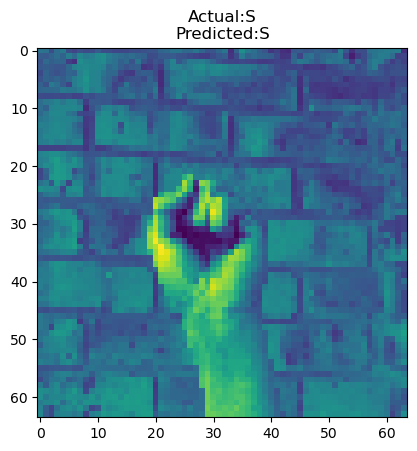

In [38]:
img=val_images_norm[0:1]
label = model.predict(img)
index=np.argmax(label)
plt.imshow(val_images[0])
plt.title(f"Actual:{val_labels[0]}\nPredicted:{labels[index]}")
plt.show()

In [ ]:
img=test_images_norm[3:4]
label = model.predict(img)
index=np.argmax(label)
plt.imshow(test_images[2])
plt.title(f"Actual:{test_labels[2]}\nPredicted:{labels[index]}")
plt.show()

# Tentativo PCA+Rete Neurale

In [77]:
pca = PCA(0.9)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_images_vectorized)

In [86]:
val_pca = pca.transform(val_images_vectorized)

In [79]:
train_pca.shape

(69600, 40)

In [80]:
model_2 = models.Sequential([
    layers.Dense(40, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [81]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [82]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [85]:
model_2.fit(train_pca, train_labels_encoded, epochs=100,validation_data=[val_pca,val_labels_encoded],callbacks=[early_stopping_callback])

Epoch 1/100
2175/2175 [==============================] - 3s 1ms/step - loss: 2.8728 - accuracy: 0.1518 - val_loss: 2.6318 - val_accuracy: 0.1968
Epoch 2/100
2175/2175 [==============================] - 2s 924us/step - loss: 2.4270 - accuracy: 0.2547 - val_loss: 2.2655 - val_accuracy: 0.2928
Epoch 3/100
2175/2175 [==============================] - 2s 933us/step - loss: 2.1176 - accuracy: 0.3390 - val_loss: 1.9879 - val_accuracy: 0.3706
Epoch 4/100
2175/2175 [==============================] - 2s 951us/step - loss: 1.8738 - accuracy: 0.4103 - val_loss: 1.7685 - val_accuracy: 0.4369
Epoch 5/100
2175/2175 [==============================] - 2s 937us/step - loss: 1.6659 - accuracy: 0.4744 - val_loss: 1.5732 - val_accuracy: 0.5007
Epoch 6/100
2175/2175 [==============================] - 2s 936us/step - loss: 1.4953 - accuracy: 0.5261 - val_loss: 1.4140 - val_accuracy: 0.5466
Epoch 7/100
2175/2175 [==============================] - 2s 967us/step - loss: 1.3609 - accuracy: 0.5657 - val_loss: 1.2

# Tentativo 2 PCA+Rete Neurale

In [87]:
pca = PCA(0.8)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_images_vectorized)

In [88]:
val_pca = pca.transform(val_images_vectorized)

In [89]:
train_pca.shape

(69600, 12)

In [91]:
model_3 = models.Sequential([
    layers.Dense(12, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [92]:
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [93]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [94]:
model_3.fit(train_pca, train_labels_encoded, epochs=100,validation_data=[val_pca,val_labels_encoded],callbacks=[early_stopping_callback])

Epoch 1/100
2175/2175 [==============================] - 2s 938us/step - loss: 3.0970 - accuracy: 0.1098 - val_loss: 2.9551 - val_accuracy: 0.1334
Epoch 2/100
2175/2175 [==============================] - 2s 871us/step - loss: 2.8759 - accuracy: 0.1574 - val_loss: 2.7928 - val_accuracy: 0.1772
Epoch 3/100
2175/2175 [==============================] - 2s 872us/step - loss: 2.6907 - accuracy: 0.1992 - val_loss: 2.5790 - val_accuracy: 0.2203
Epoch 4/100
2175/2175 [==============================] - 2s 878us/step - loss: 2.4841 - accuracy: 0.2493 - val_loss: 2.3827 - val_accuracy: 0.2689
Epoch 5/100
2175/2175 [==============================] - 2s 895us/step - loss: 2.3021 - accuracy: 0.2941 - val_loss: 2.2220 - val_accuracy: 0.3101
Epoch 6/100
2175/2175 [==============================] - 2s 886us/step - loss: 2.1585 - accuracy: 0.3287 - val_loss: 2.0911 - val_accuracy: 0.3464
Epoch 7/100
2175/2175 [==============================] - 2s 894us/step - loss: 2.0428 - accuracy: 0.3605 - val_loss: 1

forse la varianza rappresentata non è abbastanza

# Tuning degli iperparametri

In [95]:
pca = PCA(0.90)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_images_vectorized)

In [96]:
val_pca = pca.transform(val_images_vectorized)

In [180]:
model_3_pca = models.Sequential([
    layers.Dense(40, activation='tanh'),
    layers.Dense(256, activation='relu6'),
    layers.Dense(29, activation='softmax')
])

In [181]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [100]:
from bayes_opt import BayesianOptimization
def create_model(dense_units1,learning_rate):
    model = models.Sequential([
        layers.Dense(111, activation='tanh'),
        layers.Dense(int(dense_units1), activation='relu6'),
        layers.Dense(29, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def objective(dense_units1, learning_rate):
    model = create_model(dense_units1,learning_rate)
    
    history = model.fit(train_pca, train_labels_encoded,
                        validation_data=(val_pca, val_labels_encoded),
                        epochs=10,
                        batch_size=32,verbose=0)
    
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Imposta i parametri di ricerca
pbounds = {
    'learning_rate':(0.0001,0.001),
    'dense_units1': (128, 512),
    
    
}
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

# Avvia l'ottimizzazione
optimizer.maximize(init_points=5, n_iter=10)

# Visualizza i migliori parametri trovati
print("Best hyperparameters: ", optimizer.max)

|   iter    |  target   | dense_... | learni... |
-------------------------------------------------
| 1         | 0.7912    | 271.8     | 0.0009556 |
| 2         | 0.7388    | 409.1     | 0.0006388 |
| 3         | 0.4054    | 187.9     | 0.0002404 |
| 4         | 0.7003    | 150.3     | 0.0008796 |
| 5         | 0.7661    | 358.8     | 0.0007373 |
| 6         | 0.4602    | 270.4     | 0.0002659 |
| 7         | 0.7995    | 271.9     | 0.0009935 |
| 8         | 0.7466    | 273.6     | 0.000761  |
| 9         | 0.7859    | 357.1     | 0.0008424 |
| 10        | 0.4278    | 355.3     | 0.0002092 |
| 11        | 0.6643    | 360.6     | 0.0005015 |
| 12        | 0.6979    | 407.4     | 0.0005044 |
| 13        | 0.572     | 410.8     | 0.0003348 |
| 14        | 0.6891    | 357.9     | 0.0005404 |
| 15        | 0.7152    | 274.9     | 0.0006968 |
Best hyperparameters:  {'target': 0.7995402216911316, 'params': {'dense_units1': 271.9272824639362, 'learning_rate': 0.0009935486153941585}}


In [102]:
model_1 = create_model(optimizer.max["params"]["dense_units1"],optimizer.max["params"]["learning_rate"])

In [103]:
model_1.fit(train_pca, train_labels_encoded, epochs=100, batch_size=32,validation_data=(val_pca, val_labels_encoded),callbacks=[early_stopping_callback])

Epoch 1/100
2175/2175 [==============================] - 3s 1ms/step - loss: 2.7025 - accuracy: 0.1957 - val_loss: 2.3179 - val_accuracy: 0.2817
Epoch 2/100
2175/2175 [==============================] - 3s 1ms/step - loss: 2.0572 - accuracy: 0.3579 - val_loss: 1.8320 - val_accuracy: 0.4222
Epoch 3/100
2175/2175 [==============================] - 3s 1ms/step - loss: 1.6657 - accuracy: 0.4754 - val_loss: 1.5155 - val_accuracy: 0.5236
Epoch 4/100
2175/2175 [==============================] - 3s 1ms/step - loss: 1.3876 - accuracy: 0.5591 - val_loss: 1.2832 - val_accuracy: 0.5930
Epoch 5/100
2175/2175 [==============================] - 3s 1ms/step - loss: 1.1842 - accuracy: 0.6231 - val_loss: 1.0986 - val_accuracy: 0.6529
Epoch 6/100
2175/2175 [==============================] - 2s 1ms/step - loss: 1.0363 - accuracy: 0.6686 - val_loss: 0.9720 - val_accuracy: 0.6965
Epoch 7/100
2175/2175 [==============================] - 3s 1ms/step - loss: 0.9181 - accuracy: 0.7088 - val_loss: 0.8723 - val_ac

In [105]:
model_1.save("./Modelli/PCA_NN")

INFO:tensorflow:Assets written to: ./Modelli/PCA_NN/assets


# CNN 

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [23]:
model = Sequential()

model = models.Sequential()
# 1st convolution layer
model.add(Conv2D(16, kernel_size=(2, 2), activation='relu', padding='same', input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(16, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# fully-connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(29, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        208       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 21, 21, 16)       64        
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 21, 21, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 16)        1040      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 16)        

In [24]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [25]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

prima_addestrato con adam e poi con sgd strano

In [33]:
train_images_norm.shape

(69600, 100, 100, 3)

In [26]:
model.fit(train_images_norm, train_labels_encoded, epochs=100, batch_size=64,validation_data=(val_images_norm, val_labels_encoded),callbacks=[early_stopping_callback],shuffle=True)

Epoch 1/100
1088/1088 [==============================] - 55s 50ms/step - loss: 1.6226 - accuracy: 0.4964 - val_loss: 2.7312 - val_accuracy: 0.3995
Epoch 2/100
1088/1088 [==============================] - 50s 46ms/step - loss: 0.7628 - accuracy: 0.7379 - val_loss: 2.3411 - val_accuracy: 0.4898
Epoch 3/100
1088/1088 [==============================] - 46s 42ms/step - loss: 0.5555 - accuracy: 0.8064 - val_loss: 1.8648 - val_accuracy: 0.5565
Epoch 4/100
1088/1088 [==============================] - 43s 39ms/step - loss: 0.4470 - accuracy: 0.8442 - val_loss: 2.2476 - val_accuracy: 0.5260
Epoch 5/100
1088/1088 [==============================] - 42s 39ms/step - loss: 0.3877 - accuracy: 0.8644 - val_loss: 2.0530 - val_accuracy: 0.5856
Epoch 6/100
1088/1088 [==============================] - 43s 39ms/step - loss: 0.3391 - accuracy: 0.8814 - val_loss: 1.8312 - val_accuracy: 0.6010
Epoch 7/100
1088/1088 [==============================] - 46s 42ms/step - loss: 0.3136 - accuracy: 0.8896 - val_loss: 1

In [95]:
model.save("./Modelli/cnn_3")

INFO:tensorflow:Assets written to: ./Modelli/cnn_3/assets


INFO:tensorflow:Assets written to: ./Modelli/cnn_3/assets


In [130]:
model = models.load_model("./Modelli/cnn")

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        208       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 21, 21, 16)       64        
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 21, 21, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 16)        1040      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 16)        

# Landmarks

In [4]:
import cv2
import mediapipe as mp
import numpy as np

# Inizializza Mediapipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

def process_images_with_mediapipe(images,labels):
    landmarks_list = []
    skipped_index = []
    i = 0
    for img in tqdm(images, desc="Elaborazione delle immagini"):
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = hands.process(img_rgb)
                
        if result.multi_hand_landmarks:
            hand_landmarks = result.multi_hand_landmarks[0]  # Estrai solo i landmarks della mano dominante
            # Estrai le coordinate x e y dei punti di riferimento delle mani
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.append(lm.x)
                landmarks.append(lm.y)

        else:
            if(labels[i]!="nothing"):
               skipped_index.append(i)
            landmarks =  np.zeros(42)
        landmarks_list.append(landmarks)
        i+=1
    print("Skipped:",len(skipped_index))
    return landmarks_list,skipped_index


train_images_landmarks,skipped_index = process_images_with_mediapipe(train_images,train_labels)

hands.close()


Elaborazione delle immagini: 100%|██████████| 87000/87000 [30:44<00:00, 47.17it/s]   

Skipped: 20327


In [16]:
np.save("landmarks",train_images_landmarks)

In [5]:
landmarks_np= np.array(train_images_landmarks)

In [7]:
landmarks_np_cleaned = np.delete(landmarks_np,skipped_index,axis=0)
labels_cleaned = np.delete(train_labels,skipped_index)

In [13]:
np.save("train_images_landmarks", landmarks_np_cleaned)
np.save("train_images_labels", labels_cleaned)

In [4]:
landmarks_np_cleaned=np.load("train_images_landmarks_cleaned.npy")

In [5]:
labels_cleaned = np.load("./landmarks/train_images_labels_cleaned.npy")

In [15]:
x_train,x_val,y_train,y_val = train_test_split(landmarks_np_cleaned,labels_cleaned,random_state=42)

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [18]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)

In [19]:
model_landmarks = models.Sequential([
    layers.Dense(42, activation='relu'),
    layers.Dense(256, activation='relu'),
     layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [23]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [21]:
model_landmarks.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model_landmarks.fit(x_train, y_train_encoded, epochs=100, batch_size=32,validation_data=(x_val, y_val_encoded),callbacks=[early_stopping_callback])

Epoch 1/100
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0800 - accuracy: 0.9757 - val_loss: 0.0737 - val_accuracy: 0.9815
Epoch 2/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0732 - accuracy: 0.9782 - val_loss: 0.0644 - val_accuracy: 0.9840
Epoch 3/100
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0705 - accuracy: 0.9784 - val_loss: 0.1049 - val_accuracy: 0.9718
Epoch 4/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0642 - accuracy: 0.9800 - val_loss: 0.0948 - val_accuracy: 0.9742
Epoch 5/100
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0589 - accuracy: 0.9808 - val_loss: 0.0708 - val_accuracy: 0.9822


In [25]:
model_landmarks.save("./Modelli/nn_landmarks")

INFO:tensorflow:Assets written to: ./Modelli/nn_landmarks\assets


In [32]:
clf = DecisionTreeClassifier(random_state=42)

# Addestra il modello
clf.fit(x_train, y_train)

# Predice i valori di test
y_pred = clf.predict(x_train)

# Calcola l'accuratezza del modello
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [33]:
y_pred = clf.predict(x_val)

# Calcola l'accuratezza del modello
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.93


In [37]:
import pickle

# Supponiamo di avere un modello addestrato chiamato 'model'
with open('./Modelli/tree.pkl', 'wb') as file:
    pickle.dump(clf, file)
